# TinyLLM: A Small Transformer for Text Generation 
## Rodolphe Cledassou School 2025

> Marc Huertas-Company & Hubert Bretonnière

This notebook trains a **tiny Transformer decoder** (a minimal LLM) for **character-level** text generation using a small dataset from Hugging Face. It is designed to be **simple, fast, and pedagogical**, so it can run on a laptop (CPU or Mac MPS).

What you'll see:
- Loading a tiny dataset (**Tiny Shakespeare**).
- Building a **char-level tokenizer** from scratch.
- Implementing a **Transformer decoder** (multi-head self-attention + MLP).
- Training with cross-entropy next-token prediction.
- **Sampling** with temperature and top-*k*.
- **Attention map** visualizations for interpretability.

## 0) Setup (device & optional installs)

If you don't have the `datasets` library, uncomment the first cell to install.

**What this cell does (Setup & Device):**
- Imports core libraries (`torch`, `datasets`) and picks a compute **device**:
  - Prefer **MPS** (Apple Metal) on Macs, then **CUDA**, else **CPU**.
- Sets **random seeds** for reproducibility.
- If `datasets` is missing, you can `pip install datasets` (comment in the cell).
**Key ideas:** you must move both **model** and **batches** to the same device.

In [1]:
# If needed, uncomment:
# %pip install -q datasets

import math, time, random, os, sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset

device = (
    torch.device("mps") if torch.backends.mps.is_available()
    else torch.device("cuda") if torch.cuda.is_available()
    else torch.device("cpu")
)
print("Using device:", device)

torch.manual_seed(42); np.random.seed(42); random.seed(42)

/Users/marchuertascompany/soft/miniforge3/envs/spender/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: mps


## 1) Load a tiny dataset (Tiny Shakespeare)

We use the **`tiny_shakespeare`** dataset (about 1 MB). It's small but has rich structure to learn character-level language modeling.

- We concatenate the text into one long string.
- Then we will split into **train/val** segments.

**What this cell does (Data loading):**
- Downloads the **Tiny Shakespeare** corpus from 🤗 Datasets.
- Concatenates all text chunks into a single string `raw_text` for easy indexing.
**Why:** character-level LM treats the entire corpus as one long stream of tokens.
**Tip:** If `tiny_shakespeare` fails on your setup, switch to the generic text loader with a raw URL.

In [2]:
from datasets import load_dataset

try:
    ds = load_dataset("winglian/tiny-shakespeare")
    raw_text = "\n".join(ds["train"]["text"])
except Exception:
    ds = load_dataset(
        "text",
        data_files={"train": "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"},
    )
    raw_text = "\n".join(ds["train"]["text"])
print(raw_text[:500])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor


## 2) Character vocabulary & encoding/decoding

For pedagogy, we do **character-level** modeling:
- Build `vocab` as the sorted unique characters in the dataset.
- Create `stoi` / `itos` maps to encode/decode between text and integer IDs.

**What this cell does (Character vocabulary):**
- Builds a **character-level vocabulary** from unique chars in the corpus.
- Creates maps:
  - `stoi` (string→id) to **encode** text to integers.
  - `itos` (id→string) to **decode** integers back to text.
**Why:** this avoids an external tokenizer and keeps the tutorial minimal.

In [3]:
chars = sorted(list(set(raw_text)))
vocab_size = len(chars)
print("Vocab size:", vocab_size)
print("First 100 chars of vocab:", "".join(chars[:100]))

stoi = {ch:i for i,ch in enumerate(chars)}
itos = {i:ch for ch,i in stoi.items()}

def encode(s: str):
    return [stoi[c] for c in s]

def decode(ids):
    return "".join(itos[i] for i in ids)

Vocab size: 65
First 100 chars of vocab: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


## 3) Train/Val split and batching

- Convert the entire text into a **1D tensor of token IDs**.
- Split into **90% train** and **10% val**.
- Define a `get_batch(split)` function that samples random contiguous blocks of length **`block_size`**.

**What this cell does (Train/Val split & batching):**
- Converts the entire text into a 1D tensor of token IDs.
- Splits into **90% train** / **10% validation**.
- Defines `block_size` (context window) and `batch_size`.
- Implements `get_batch(split)` that samples random **contiguous** windows:
  - `x` is tokens `[t, t+1, ..., t+block_size-1]`
  - `y` is next tokens `[t+1, ..., t+block_size]`
**Why:** next-token prediction trains the model to predict the next character given the previous **context**.

In [4]:
data = torch.tensor(encode(raw_text), dtype=torch.long)

n = int(0.9 * len(data))
train_ids = data[:n]
val_ids   = data[n:]

block_size = 128
batch_size = 64
print(f"Train tokens: {train_ids.numel():,} | Val tokens: {val_ids.numel():,}")

def get_batch(split):
    ids = train_ids if split == "train" else val_ids
    ix = torch.randint(0, len(ids) - block_size - 1, (batch_size,))
    x = torch.stack([ids[i:i+block_size] for i in ix])
    y = torch.stack([ids[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

Train tokens: 1,100,542 | Val tokens: 122,283


## 4) Tiny Transformer decoder (from scratch)

**What this cell does (Tiny Transformer model):**
- Implements a **GPT-style** decoder block from scratch:
  - **Token & positional embeddings** (learned).
  - **Causal multi-head self-attention** with a **lower-triangular mask** so tokens cannot see the future.
  - **Pre-LayerNorm** + **MLP** with GELU and residual connections.
- The attention step computes `softmax(QKᵀ/√d)·V`, then projects back to the model dimension.
**Outputs:** logits over the vocabulary for each position; if `targets` given, returns **cross-entropy loss**.

In [5]:
class CausalSelfAttention(nn.Module):
    def __init__(self, n_embd, n_head, dropout, block_size):
        super().__init__()
        assert n_embd % n_head == 0
        self.n_head = n_head
        self.head_dim = n_embd // n_head

        self.q_proj = nn.Linear(n_embd, n_embd)
        self.k_proj = nn.Linear(n_embd, n_embd)
        self.v_proj = nn.Linear(n_embd, n_embd)
        self.out_proj = nn.Linear(n_embd, n_embd)
        self.attn_drop = nn.Dropout(dropout)
        self.resid_drop = nn.Dropout(dropout)

        mask = torch.tril(torch.ones(block_size, block_size)).view(1, 1, block_size, block_size)
        self.register_buffer("mask", mask)

    def forward(self, x, return_attn=False):
        B, T, C = x.shape
        q = self.q_proj(x).view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        k = self.k_proj(x).view(B, T, self.n_head, self.head_dim).transpose(1, 2)
        v = self.v_proj(x).view(B, T, self.n_head, self.head_dim).transpose(1, 2)

        att = (q @ k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        att = att.masked_fill(self.mask[:, :, :T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_drop(att)

        y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, T, -1)
        y = self.resid_drop(self.out_proj(y))
        if return_attn:
            return y, att
        return y

class Block(nn.Module):
    def __init__(self, n_embd, n_head, dropout, block_size):
        super().__init__()
        self.ln1 = nn.LayerNorm(n_embd)
        self.sa = CausalSelfAttention(n_embd, n_head, dropout, block_size)
        self.ln2 = nn.LayerNorm(n_embd)
        self.mlp = nn.Sequential(
            nn.Linear(n_embd, 4*n_embd),
            nn.GELU(),
            nn.Linear(4*n_embd, n_embd),
            nn.Dropout(dropout),
        )
    def forward(self, x, return_attn=False):
        if return_attn:
            y, att = self.sa(self.ln1(x), return_attn=True)
            x = x + y
            x = x + self.mlp(self.ln2(x))
            return x, att
        else:
            x = x + self.sa(self.ln1(x))
            x = x + self.mlp(self.ln2(x))
            return x

class TinyTransformer(nn.Module):
    def __init__(self, vocab_size, n_embd=128, n_head=4, n_layer=4, block_size=128, dropout=0.1):
        super().__init__()
        self.block_size = block_size
        self.tok_emb = nn.Embedding(vocab_size, n_embd)
        self.pos_emb = nn.Embedding(block_size, n_embd)
        self.drop = nn.Dropout(dropout)
        self.blocks = nn.ModuleList([Block(n_embd, n_head, dropout, block_size) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.head = nn.Linear(n_embd, vocab_size)
        self.head.weight = self.tok_emb.weight  # weight tying

    def forward(self, idx, targets=None, return_attn=False):
        B, T = idx.shape
        assert T <= self.block_size
        tok = self.tok_emb(idx)
        pos = self.pos_emb(torch.arange(T, device=idx.device))
        x = self.drop(tok + pos)

        attn_maps = [] if return_attn else None
        for blk in self.blocks:
            if return_attn:
                x, att = blk(x, return_attn=True)
                attn_maps.append(att)
            else:
                x = blk(x)
        x = self.ln_f(x)
        logits = self.head(x)
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        if return_attn:
            return logits, loss, attn_maps
        return logits, loss

### Hyperparameters & model init

**What this cell does (Hyperparameters & initialization):**
- Sets small, laptop-friendly sizes: embedding dim, heads, layers, dropout.
- Instantiates the model and an **AdamW** optimizer.
- Uses **weight tying** (output head shares weights with token embeddings) to reduce parameters and help training.
**Rule of thumb:** larger `block_size` ⇒ longer context but more compute; start small and scale up gradually.

In [6]:
n_embd = 128; n_head = 4; n_layer = 4; dropout = 0.1
model = TinyTransformer(vocab_size, n_embd, n_head, n_layer, block_size, dropout).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-2)
print("Parameters (M):", sum(p.numel() for p in model.parameters())/1e6)

Parameters (M): 0.818113


## 5) Training loop

**What this cell does (Training loop):**
- Trains for a few hundred steps with **cross-entropy** next-token loss.
- Every `eval_interval`, runs a quick **validation** estimate (no grad).
- Uses **gradient clipping** to avoid exploding gradients.
**Watch:** training loss should go down; validation loss may be a bit higher.

In [11]:
max_steps = 5000
eval_interval = 100
log_every = 50

def estimate_loss():
    model.eval()
    out = {}
    with torch.no_grad():
        for split in ["train", "val"]:
            losses = []
            for _ in range(20):
                xb, yb = get_batch("train" if split=="train" else "val")
                _, loss = model(xb, yb)
                losses.append(loss.item())
            out[split] = sum(losses)/len(losses)
    model.train()
    return out

model.train()
for step in range(1, max_steps+1):
    xb, yb = get_batch("train")
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

    if step % log_every == 0:
        print(f"step {step:4d} | train loss {loss.item():.3f}")
    if step % eval_interval == 0 or step == max_steps:
        losses = estimate_loss()
        print(f"[eval] step {step} | train {losses['train']:.3f} | val {losses['val']:.3f}")

step   50 | train loss 2.555
step  100 | train loss 2.553
[eval] step 100 | train 2.431 | val 2.453
step  150 | train loss 2.490
step  200 | train loss 2.491
[eval] step 200 | train 2.414 | val 2.438
step  250 | train loss 2.512
step  300 | train loss 2.465
[eval] step 300 | train 2.375 | val 2.400
step  350 | train loss 2.510
step  400 | train loss 2.449
[eval] step 400 | train 2.359 | val 2.390
step  450 | train loss 2.438
step  500 | train loss 2.409
[eval] step 500 | train 2.294 | val 2.335
step  550 | train loss 2.403
step  600 | train loss 2.422
[eval] step 600 | train 2.260 | val 2.298
step  650 | train loss 2.395
step  700 | train loss 2.343
[eval] step 700 | train 2.244 | val 2.283
step  750 | train loss 2.364
step  800 | train loss 2.349
[eval] step 800 | train 2.205 | val 2.239
step  850 | train loss 2.334
step  900 | train loss 2.285
[eval] step 900 | train 2.176 | val 2.213
step  950 | train loss 2.264
step 1000 | train loss 2.249
[eval] step 1000 | train 2.140 | val 2.185

## 6) Sampling (temperature & top-k)

**What this cell does (Autoregressive sampling):**
- Implements greedy/tempered **sampling**:
  - Crops to the last `block_size` tokens (context window).
  - Applies **temperature** (higher ⇒ more randomness).
  - Optional **top-k** filtering keeps only the top-k logits (sharper outputs).
- Generates new characters step-by-step appended to the prompt.
**Tip:** try different temperatures (e.g., 0.7, 1.0, 1.3) and `top_k` (e.g., 20, 40) to see the effect.

In [13]:
@torch.no_grad()
def generate(model, idx, max_new_tokens=200, temperature=1.0, top_k=None):
    model.eval()
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -model.block_size:]
        logits, _ = model(idx_cond)
        logits = logits[:, -1, :] / max(1e-8, temperature)
        if top_k is not None:
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float('inf')
        probs = F.softmax(logits, dim=-1)
        next_id = torch.multinomial(probs, num_samples=1)
        idx = torch.cat([idx, next_id], dim=1)
    return idx

prompt = "ROMEO:"
prompt_ids = torch.tensor([ [stoi[c] for c in prompt] ], dtype=torch.long, device=device)
gen_ids = generate(model, prompt_ids, max_new_tokens=300, temperature=0.9, top_k=40)
print("=== SAMPLE ===")
print("".join(itos[i] for i in gen_ids[0].tolist()))

=== SAMPLE ===
ROMEO:
And shall sir veity. 
Marmagainss:
With and mors the the peace.

CLARENCE:
Nay, for but your orcarfew repicity.

QUEEN MARGARET:
And like the love degriegedut; must, chince the
That the comenty, besking in haved thim hous lace
The blee his your retled unds nund my savend word
The hand poin a your I


## 7) Attention maps (visualization)

**What this cell does (Attention visualization):**
- Runs a short prompt through the model while collecting **attention weights**.
- Plots one **head** of one **layer** as a heatmap:
  - Rows = **query** positions (current token).
  - Columns = **key** positions (context tokens).
  - Brighter = higher attention weight.
**Why:** attention maps give intuition about which characters/positions the model focuses on.

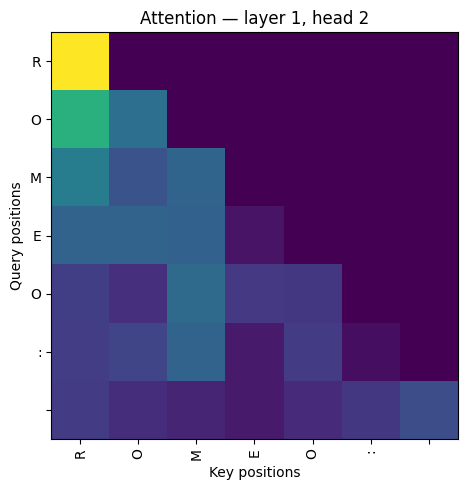

In [17]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    sample_text = "ROMEO:\n"
    idx = torch.tensor([[stoi[c] for c in sample_text]], dtype=torch.long, device=device)
    idx = idx[:, :min(idx.size(1), model.block_size)]
    logits, loss, attn_maps = model(idx, targets=None, return_attn=True)

layer_to_show = 1
head_to_show = 2
att = attn_maps[layer_to_show][0, head_to_show].cpu().numpy()
tokens = list(sample_text[:att.shape[0]])

plt.figure(figsize=(6,5))
plt.imshow(att)
plt.xticks(range(len(tokens)), tokens, rotation=90)
plt.yticks(range(len(tokens)), tokens)
plt.xlabel("Key positions"); plt.ylabel("Query positions")
plt.title(f"Attention — layer {layer_to_show}, head {head_to_show}")
plt.tight_layout(); plt.show()

## 8) Next steps
- Try more steps or a slightly larger model.
- Switch to **subword tokenization** (BPE) for more realistic language modeling.
- Add **learning rate schedules**, **dropout tuning**, or **checkpointing**.
- Visualize attention across different layers/heads and for different prompts.